## Importações

In [81]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from scipy import fftpack
from PIL import Image
import PIL
import cv2

## Funções auxiliares

In [82]:
def entropy(img):
    img = img.astype(np.float32)
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    ent = -1 * (hist*logs).sum()

    return ent

## Definições de funções de compressão/decompressão

In [83]:
JPEG_M = np.matrix([
                [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]
])

JPEG_M = JPEG_M.astype(float)

In [137]:
def compress(image, gs = 8, thresh = 0.1):
    n = np.size(image,0)
    m = np.size(image,1)

    matrix = np.zeros((n, m), dtype=float)

    image = image - 128

    for i in range(0, n, gs):
        for j in range(0, m, gs):
            matrix[i:i+gs, j:j+gs] = fftpack.dct(fftpack.dct(image[i:i+gs, j:j+gs], axis=0, norm='ortho'), axis=1, norm="ortho")
            matrix[i:i+gs, j:j+gs] = np.divide(matrix[i:i+gs, j:j+gs], JPEG_M)

    # quantized = matrix * (np.absolute(matrix) > thresh*np.max(np.absolute(matrix)))
    return np.int16(matrix.round())

In [138]:
def decompress(dct_matrix, groupSize = 8):
    n = np.size(dct_matrix,0)
    m = np.size(dct_matrix,1)

    matrix = np.zeros((n, m), dtype=float)

    for i in range(0, n, groupSize):
        for j in range(0, m, groupSize):
            matrix[i:i+groupSize, j:j+groupSize] = np.multiply(dct_matrix[i:i+groupSize, j:j+groupSize], JPEG_M)
            matrix[i:i+groupSize, j:j+groupSize] = fftpack.idct(fftpack.idct(matrix[i:i+groupSize, j:j+groupSize], axis=0, norm='ortho'), axis=1, norm="ortho")

    return matrix + 128

## Definições de funções de codificação

In [86]:
def delta_encoder(matrix):
    shape = matrix.shape

    vectorizer = matrix.flatten()
    original = vectorizer.copy()

    for i in range(1, len(vectorizer)):
        vectorizer[i] -= original[i-1]

    return vectorizer.reshape(shape)

def delta_decoder(matrix):
    shape = matrix.shape

    vectorizer = matrix.flatten()
    original = vectorizer.copy()

    for i in range(1, len(vectorizer)):
            vectorizer[i] += vectorizer[i-1]

    return vectorizer.reshape(shape)

In [87]:
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

In [88]:
def apply_huffman(frequency, npixels):
  huff = encode(frequency)

  print ("Symbol\tWeight\t\tHuffman Code")
  nbits = 0

  for p in huff:
      if (frequency[p[0]] > 0):
          # print("%d\t%f\t%s" % (p[0], freq[p[0]], p[1]))
          nbits += frequency[p[0]]*len(p[1])
  print("...")

  return nbits, nbits/npixels, huff

In [89]:
def get_frequency_table(image):
  freq = {}
  for arr in image:
    for v in arr:
      v = str(v)
      try:
          freq[v] += 1
      except KeyError:
          freq[v] = 1
  return freq

In [90]:
sep = "|"

def create_header_bits(shape, table):
  bits = f"{shape[0]}{sep}{shape[1]}{sep}"

  for k, v in table.items():
    bits += str(k) + ":" + str(v) + sep

  return bits.encode()

In [91]:
sep_context = "]"

def create_image_bits(table, img):
  bits = str()

  for arr in img:
    for v in arr:
      bits += table[str(v)]
  binary_bytes = bytes(int(bits[i:i+8], 2) for i in range(0, len(bits), 8))
  return binary_bytes, bits

In [92]:
import numpy as np

def zigzag_order(matrix):
    # Obtém as dimensões da matriz (deve ser uma matriz 8x8)
    rows, cols = matrix.shape

    if rows != 8 or cols != 8:
        raise ValueError("A matriz deve ser 8x8 para a ordenação zigzag.")

    # Vetor para armazenar os valores na ordem zigzag
    zigzag = []

    # Inicia o percurso no canto superior esquerdo
    row, col = 0, 0

    # Flag para inverter a direção do percurso
    going_up = True

    for _ in range(8 * 8):
        zigzag.append(matrix[row, col])

        if going_up:
            if col == 7:
                row += 1
                going_up = False
            elif row == 0:
                col += 1
                going_up = False
            else:
                row -= 1
                col += 1
        else:
            if row == 7:
                col += 1
                going_up = True
            elif col == 0:
                row += 1
                going_up = True
            else:
                row += 1
                col -= 1

    return np.array(zigzag).flatten().tolist()

In [93]:
import numpy as np

def matriz_a_partir_do_zigzag(vetor_zigzag):
    # Cria uma matriz vazia 8x8
    matriz = np.zeros((8, 8))

    # Inicializa as variáveis de posição na matriz
    row, col = 0, 0

    # Flag para inverter a direção do percurso
    going_up = True

    # Percorre o vetor zigzag e preenche a matriz
    for valor in vetor_zigzag:
        matriz[row, col] = valor

        if going_up:
            if col == 7:
                row += 1
                going_up = False
            elif row == 0:
                col += 1
                going_up = False
            else:
                row -= 1
                col += 1
        else:
            if row == 7:
                col += 1
                going_up = True
            elif col == 0:
                row += 1
                going_up = True
            else:
                row += 1
                col -= 1

    return matriz



In [94]:
def ultima_ocorrencia_diferente_de_zero(arr):
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] != 0:
            return i
    return -1  # Retorna -1 se não houver nenhum número diferente de zero no array


## Aplicação

In [139]:
# Importando imagem
img = data.camera()
img = np.array(img).astype(float)

In [140]:
# Definição de parâmetros
group_size = 8
thresh = 0.015

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [142]:
# Aplicando transformadas
compressed_img = compress(img, group_size, thresh)
decompressed_img = decompress(compressed_img, group_size)

In [143]:
print("Entropia com as codificações aplicadas\n")
print("Original\tSem delta\tDelta\t\tDescomprimida")
print("%f\t%f\t%f\t%f" % (entropy(img), entropy(compressed_img), entropy(delta_encoder(compressed_img)), entropy(decompressed_img)))

Entropia com as codificações aplicadas

Original	Sem delta	Delta		Descomprimida
7.228034	0.550698	0.758707	6.999050


In [144]:
zigzag_image = []
for i in range(0, compressed_img.shape[0], 8):
    for j in range(0, compressed_img.shape[1],8):
        x = zigzag_order(compressed_img[i:i+8, j:j+8])
        last = ultima_ocorrencia_diferente_de_zero(x)
        if(last != -1):
            x = [v for v in x[:last+1]]
        x += ['EOB']
        zigzag_image.append(x)

In [145]:
frequency = get_frequency_table(zigzag_image)

nbits, bpp, huff = apply_huffman(frequency, compressed_img.size)

huffman_table = {k: v for k, v in huff}

header = create_header_bits(compressed_img.shape, frequency)
image, bit = create_image_bits(huffman_table, zigzag_image)

compressed_file = header + sep_context.encode() + image

with open("compressed.bin", "wb") as file:
  file.write(compressed_file)


"""
[X] Fazer a função Huffman receber a tabela de frequência como parâmetro
[ ] Retornar a raiz da árvore na função
[ ] Leitura bit a bit do str_img
"""

#print("Sumário")
#print("N° Bits Orig: %d" % (img.size*8))
#print("N° Bits Huff: %d" % (nbits))
#print("%5.3f bits/pixel" % bpp)
#print("Eficiência: %5.3f" % (entropy(img) / bpp))

Symbol	Weight		Huffman Code
...


'\n[X] Fazer a função Huffman receber a tabela de frequência como parâmetro\n[ ] Retornar a raiz da árvore na função\n[ ] Leitura bit a bit do str_img\n'

In [146]:
with open("compressed.bin", "rb") as file:
  code = file.read()

for i in range(0,len(code)):
  if code[i] == 93:
    str_header = str(code[0:i])
    str_img = code[i+1:]
    break

width, height = [int(v.replace("b'", "")) for v in str_header.split(sep, 2)[:2]]

str_table = str_header.split(sep, 2)[2]

table = {str(k): int(v) for k, v in (line.split(":") for line in str_table.split(sep)[:-1])}

In [147]:
binary_string = ''.join(format(byte, '08b') for byte in image)

In [148]:
len(str_img), len(image)

(25059, 25059)

In [149]:
represent = ""
huff_table = {v: k for k, v in apply_huffman(table, width*height)[2]}

values = huff_table.keys()
blocks = []
block = []

for b in bit:
  if represent in values:
    element = huff_table[represent]
    if element == "EOB":
      block += [0]*(64-len(block))
      blocks.append(matriz_a_partir_do_zigzag(np.array(block)))
      block = []
    else:
      block.append(int(element))
    represent = ""
  represent += b

Symbol	Weight		Huffman Code
...


In [150]:
compressed_image = np.zeros((width, height))

for i, block in enumerate(blocks):
    for j, arr in enumerate(block):
        for k, v in enumerate(arr):
            lin = 8*int(i*8/width) + j
            col = int(8*(i%(width/8)) + k)
            # print(lin, col, v)
            compressed_image[lin, col] = v

In [151]:
(compressed_image == compressed_img).sum()

262124

In [152]:
512*512

262144

In [153]:
decompressed_image = decompress(compressed_image, group_size)

In [154]:
decompressed_image

array([[200., 200., 200., ..., 190., 190., 190.],
       [200., 200., 200., ..., 190., 190., 190.],
       [200., 200., 200., ..., 190., 190., 190.],
       ...,
       [ 24.,  24.,  24., ..., 128., 128., 128.],
       [ 24.,  24.,  24., ..., 128., 128., 128.],
       [ 24.,  24.,  24., ..., 128., 128., 128.]])

In [155]:
decompressed_img

array([[200.   , 200.   , 200.   , ..., 190.   , 190.   , 190.   ],
       [200.   , 200.   , 200.   , ..., 190.   , 190.   , 190.   ],
       [200.   , 200.   , 200.   , ..., 190.   , 190.   , 190.   ],
       ...,
       [ 24.   ,  24.   ,  24.   , ..., 143.171, 135.912, 161.937],
       [ 24.   ,  24.   ,  24.   , ..., 152.772, 142.887, 163.133],
       [ 24.   ,  24.   ,  24.   , ..., 154.67 , 141.006, 153.892]])

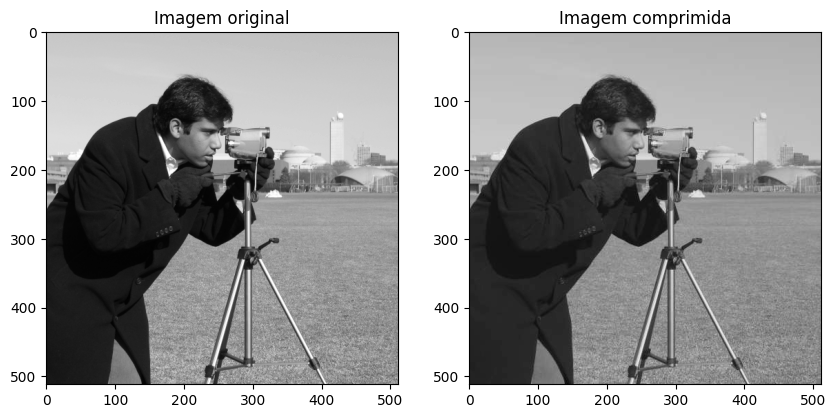

In [156]:
# Plot das duas imagens
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem original")
fig.add_subplot(1, 2, 2)
plt.imshow(decompressed_image, cmap='gray')
plt.title("Imagem comprimida")
plt.show()

In [160]:
# #Compute size of compressed image and compression ratio
frac_nonzero = np.sum(np.abs(compressed_img) != 0.0)/compressed_img.size
print("Keeping %.2f%% of DCT coefficients"%(100*frac_nonzero))
print('Taxa de compressão: %.1f:1'%(1/frac_nonzero))

#Compute Peak Signal to Noise Ratio (PSNR)
MSE = np.sum((img-decompressed_img)**2)/img.size
PSNR = 10*np.log10(np.max(img)**2/MSE)
print('MSE: %.2f'%MSE)
print('PSNR: %.2f'%PSNR)

Keeping 12.03% of DCT coefficients
Taxa de compressão: 8.3:1
MSE: 35.89
PSNR: 32.58


In [ ]:
# Salvando as imagems
plt.imsave('decompressed_img.png', np.abs(decompressed_img), cmap='gray')
plt.imsave('original.png', img, cmap='gray')

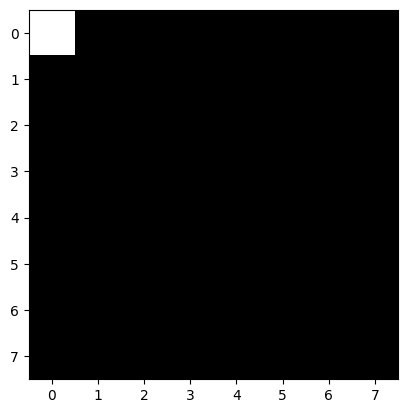

In [161]:
plt.imshow(np.log(1+np.abs(compressed_img[0:8,0:8])), cmap='gray')

In [ ]:
plt.imshow(np.log(1+np.abs(compressed_img)), cmap='gray')

In [ ]:
teste = img - 128
teste = fftpack.dct(fftpack.dct(teste,axis=0, norm="ortho"),axis=1, norm="ortho")
plt.imshow(np.log(1+np.abs(teste)), cmap='gray')